### Detección de movimiento con cámara estática

En este tutorial vamos a ver como detectar los píxeles de una imagen que cambian en un entorno con cámara fija. Veremos como crear una imagen destacando las partes de ella donde exite un cambio respecto el fondo y los objetos que se mueven.


Las grabaciones de una cámara estatica, asumiendo que la cámara graba desde cierta distancia, van a tener muchas regiones con imagenes muy parecidas. Esto se debe a que asumimos que el entorno donde grabamos no se mueve con respecto la posición de la cámara. Cámaras en pasillos, o una cámara enfocando una carretera, están bajo estas condiciones ya que ni un pasillo ni una carretera cambian demasiado con el paso del tiempo (a menos que existan obras que modifiquen la escena).





### 0) Cargando imagenes de un video

In [102]:
%matplotlib inline
import skimage
import imageio
import matplotlib 
from matplotlib import pyplot as plt
import numpy as np

In [393]:
filename = '../data/vtest.avi'
vid      = imageio.get_reader(filename,  'ffmpeg')

Podemos iterar sobre las imagenes de `vid` usando  `vid.iter_data()`. Es importante darse cuenta que en realidad podemos iterar sobre cada frame de `vid` sin necesidad de cargar todos los grames en memoria dado que `vid.iter_data()` es un objeto de python nativo de tipo `generator`.  En este caso dado que el video es pequeño podemos simplemente cargar todas las imagenes del video en una lista `images`.

In [47]:
# Lista con todas las imaganes del video
imagenes = list(vid.iter_data())

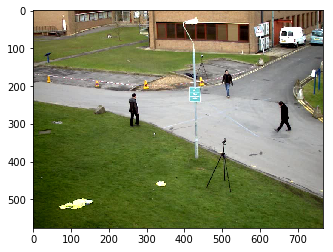

In [62]:
# Primera imagen
plt.imshow(imagenes[0])

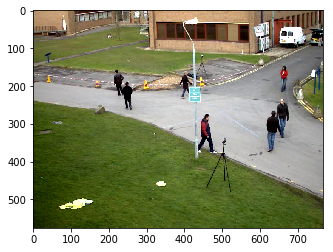

In [49]:
# Ultima imagen
plt.imshow(imagenes[-1])

In [50]:
# Numero total de frames en el video
len(imagenes)

795

In [51]:
# Dimensiones de cada frame
imagenes[0].shape

(576, 768, 3)

##### Funciones básicas de OpenCV 

- `cv2.cvtColor`: Función para convertir una imagen de un espacio de colores a otro espacio de colores.

In [52]:
import cv2

In [53]:
im_gris = cv2.cvtColor(imagenes[0], cv2.COLOR_BGR2GRAY)
im_gris

array([[135, 136, 136, ...,  78,  80,  51],
       [136, 136, 136, ...,  76,  81,  54],
       [136, 136, 136, ...,  71,  83,  59],
       ...,
       [ 23,  23,  24, ...,  52,  54,  54],
       [ 23,  23,  24, ...,  51,  52,  54],
       [ 23,  23,  24, ...,  52,  54,  56]], dtype=uint8)

In [176]:
im_gris.shape

(576, 768)

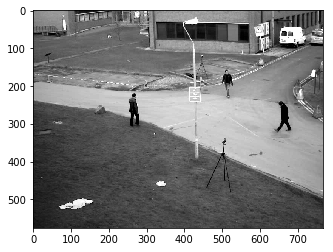

In [177]:
plt.imshow(im_gris, cmap='gray')

### 1) Substracción de fondo con cámara estatica

Consideremos que tenemos una imagen de una cámara estatica $I_s$.
Esto es, una imagen de la cámara estatica con un fondo donde no aparezcan objetos en movimiento. Podemos usar esta imagen como ¨template¨ para comparar con suscesivas imagenes.

En un instante de tiempo qualquiera $t$ podemos medir la distancia entre la imagen estatica  $I_s$ con la imagen proveniente de la cámara en tiempo $t$ que vamos a denotar con $I^{(t)}$. 

Esta distancia $d(I_s, I^{(t)})$ de una imagen estática  con una imagen refrescada en cada instante se puede usar para ver los pixeles que se han modificado. 
Si la iluminación es constante esta tecnica puede dar resultados aceptables pero una vez varie un poco la iluminación los resultados son muy malos.
Además si el objeto en movimiento tiene un color parecido al fondo puede pasar bastante inadvertido por este método.

In [153]:
# Buscar ejemplo donde tengamos una imagen de fondo

### 2) Substracción con fotogramas anteriores

#### 2.1) Substracción de imagenes consecutivas "a lo bestia"

Vamos a ver los resultados si cogemos dos frames consecutivos y simplemente computamos la diferencia entre imágenes. Primero vamos a convertir las imagenes a escala de grises usando la función `imagen_a_gris` que simplemente llama a una funcion de OpenCV (pero hace el código más leíble).

In [154]:
n_imagenes = len(imagenes)

In [155]:
n_imagenes

795

In [356]:
def imagen_a_gris(imagen):
    return cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

In [460]:
def absolute_dist(imagen1, imagen2):
    return np.abs(imagen1 - imagen2)

In [483]:
def absolute_dist(imagen1, imagen2):
    return np.abs(np.subtract(imagen1, imagen2).astype(np.int8))

In [481]:
imagenes_dif = []

for i in range(1, n_imagenes):
    imgris          = imagen_a_gris(imagenes[i])
    imgris_anterior = imagen_a_gris(imagenes[i-1])
    # NOT THIS: imagenes_dif.append(np.absolute(imgris - imgris_anterior))
    #imagenes_dif.append(absolute_dist(imgris,imgris_anterior))
    imagenes_dif.append(cv2.absdiff(imgris,imgris_anterior))

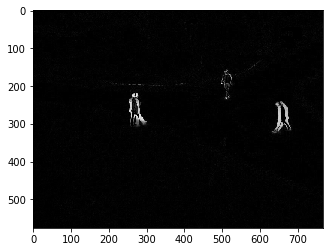

In [482]:
plt.imshow(imagenes_dif[0], cmap="gray")


Podemos observar que la diferencia entre una imagen i la imagen un instante anteior no funciona bien.

Pequeños movimientos practicamente imperceptibles en la camara o  distorciones en la imagen (viento moviendo particulas por delante de la lente) pueden hacer este metodo muy sensible.

Podemos mejorar mucho estos resultados simplemente suavizando los pixeles.

#### 2.2) Suavización de la imagen

Una manera muy sencilla de suavizar imagenes consiste en aplicar un filtro gaussiano. Lo que hace un filtro Gaussiano es simplemente a cada pixel de la imagen le aplica una suma ponderada con sus pixeles vecinos.

```
imgris_suave = cv2.GaussianBlur(imgris, (30, 30), 0)
```

In [392]:
kernel       = np.ones((5,5),np.float32)/25
imgris_suave = cv2.filter2D(imgris,-1,kernel)
imgris_suave = cv2.GaussianBlur(imgris, (21, 21), 0)

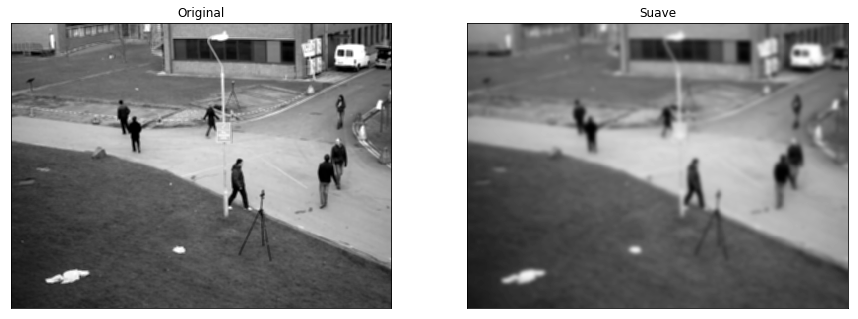

In [140]:
imagen = imagenes[0]
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgris,cmap="gray"),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(imgris_suave,cmap="gray"),plt.title('Suave')
plt.xticks([]), plt.yticks([])
plt.show()

#### Detección de movimiento suavizando a escala de grises

In [484]:
def suavizar(imagen):
    return cv2.GaussianBlur(imagen, (21, 21), 0)

In [485]:
imagenes_dif_suave = []

for i in range(1, n_imagenes):
    imgris          = imagen_a_gris(imagenes[i])
    imgris_anterior = imagen_a_gris(imagenes[i-1])
    
    imgris = suavizar(imgris)
    imgris_anterior = suavizar(imgris_anterior)
    #imagenes_dif_suave.append(np.abs(imgris - imgris_anterior))
    imagenes_dif_suave.append(cv2.absdiff(imgris,imgris_anterior))
    

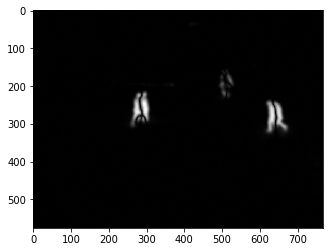

In [486]:
plt.imshow(imagenes_dif_suave[2], cmap="gray")

#### EXTRA: Posibles problemas al implementar `absdiff` con numpy

Es importante que al trabajar con `uint8` tenemos que `np.abs(Imagen1 - Imagen2)` es distinto que `np.abs(Imagen2 - Imagen1)` por lo que nos podemos llevar sorpresas.

In [395]:
imgris          = imagen_a_gris(imagenes[1])
imgris_anterior = imagen_a_gris(imagenes[0])

In [396]:
%timeit aux = absolute_dist(imgris, imgris_anterior)

166 µs ± 3.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [397]:
%timeit aux = cv2.absdiff(imgris, imgris_anterior)

68.5 µs ± 658 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### images

In [398]:
imgris          = np.array(imagen_a_gris(imagenes[1]),dtype=np.float32)
imgris_anterior = np.array(imagen_a_gris(imagenes[0]),dtype=np.float32)

i = 0
paso = 8
j = i + paso

In [399]:
imgris[i:j,i:j]

array([[137., 137., 137., 137., 138., 138., 139., 138.],
       [138., 137., 137., 137., 137., 136., 137., 136.],
       [138., 137., 137., 136., 135., 133., 133., 131.],
       [139., 138., 137., 136., 135., 132., 131., 129.],
       [139., 138., 137., 136., 135., 132., 131., 129.],
       [138., 137., 137., 136., 135., 133., 133., 131.],
       [138., 137., 137., 137., 137., 136., 137., 136.],
       [137., 137., 137., 137., 138., 138., 139., 138.]], dtype=float32)

In [400]:
imgris_anterior[i:j,i:j]

array([[135., 136., 136., 137., 138., 139., 140., 140.],
       [136., 136., 136., 137., 137., 137., 138., 138.],
       [136., 136., 136., 135., 135., 135., 133., 133.],
       [137., 136., 136., 135., 133., 132., 131., 131.],
       [137., 136., 136., 135., 133., 132., 131., 131.],
       [136., 136., 136., 135., 135., 135., 133., 133.],
       [136., 136., 136., 137., 137., 137., 138., 138.],
       [135., 136., 136., 137., 138., 139., 140., 140.]], dtype=float32)

In [401]:
cv2.absdiff(imgris, imgris_anterior)[i:j,i:j]

array([[2., 1., 1., 0., 0., 1., 1., 2.],
       [2., 1., 1., 0., 0., 1., 1., 2.],
       [2., 1., 1., 1., 0., 2., 0., 2.],
       [2., 2., 1., 1., 2., 0., 0., 2.],
       [2., 2., 1., 1., 2., 0., 0., 2.],
       [2., 1., 1., 1., 0., 2., 0., 2.],
       [2., 1., 1., 0., 0., 1., 1., 2.],
       [2., 1., 1., 0., 0., 1., 1., 2.]], dtype=float32)

In [402]:
absolute_dist(imgris[i:j,i:j], imgris_anterior[i:j,i:j])

array([[2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 1, 0, 2, 0, 2],
       [2, 2, 1, 1, 2, 0, 0, 2],
       [2, 2, 1, 1, 2, 0, 0, 2],
       [2, 1, 1, 1, 0, 2, 0, 2],
       [2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 0, 0, 1, 1, 2]], dtype=int8)

##### Trabajando con uint8 no obtenemos los mismos resultados!

In [403]:
imgris          = imagen_a_gris(imagenes[1])
imgris_anterior = imagen_a_gris(imagenes[0])

In [404]:
i = 0
paso = 8
j = i + paso
cv2.absdiff(imgris,imgris_anterior)[i:j,i:j]

array([[2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 1, 0, 2, 0, 2],
       [2, 2, 1, 1, 2, 0, 0, 2],
       [2, 2, 1, 1, 2, 0, 0, 2],
       [2, 1, 1, 1, 0, 2, 0, 2],
       [2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 0, 0, 1, 1, 2]], dtype=uint8)

In [405]:
# Notese los 255 que aparecen en las ultimas columnas
# si se opera con uint8 los resultados no son los mismos
absolute_dist(imgris[i:j,i:j], imgris_anterior[i:j,i:j])

array([[2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 1, 0, 2, 0, 2],
       [2, 2, 1, 1, 2, 0, 0, 2],
       [2, 2, 1, 1, 2, 0, 0, 2],
       [2, 1, 1, 1, 0, 2, 0, 2],
       [2, 1, 1, 0, 0, 1, 1, 2],
       [2, 1, 1, 0, 0, 1, 1, 2]], dtype=int8)

**`Uint8`** tiene un comportamiento "especial" cuando tenemos numeros negativos!

In [406]:
C1 = imgris[i:j,i:j][:,-1] 
C2 = imgris_anterior[i:j,i:j][:,-1]

In [407]:
C1

array([138, 136, 131, 129, 129, 131, 136, 138], dtype=uint8)

In [408]:
C2

array([140, 138, 133, 131, 131, 133, 138, 140], dtype=uint8)

In [409]:
np.abs(C1 - C2)

array([254, 254, 254, 254, 254, 254, 254, 254], dtype=uint8)

In [410]:
# How to change previously line to get correct result
np.abs((C1 - C2).astype(np.int8))

array([2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [411]:
np.abs(C2 - C1)

array([2, 2, 2, 2, 2, 2, 2, 2], dtype=uint8)

In [412]:
absolute_dist(C1,C2)

array([2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)

In [413]:
absolute_dist(C2,C1)

array([2, 2, 2, 2, 2, 2, 2, 2], dtype=int8)